In [112]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical,load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization



In [113]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [114]:
filenames = os.listdir("data/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [115]:
df.head()

filename  category
0   cat.0.jpg         0
1   cat.1.jpg         0
2  cat.10.jpg         0
3  cat.11.jpg         0
4  cat.12.jpg         0

In [116]:
df.tail()

filename  category
195  dog.95.jpg         1
196  dog.96.jpg         1
197  dog.97.jpg         1
198  dog.98.jpg         1
199  dog.99.jpg         1

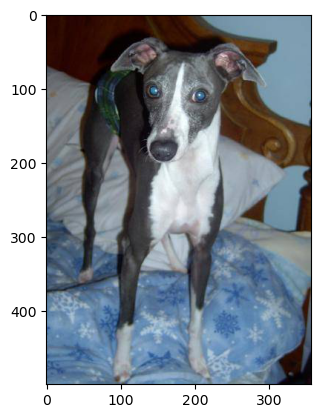

In [117]:
sample = random.choice(dog_folder)
image = load_img("data/train/"+sample)
plt.imshow(image)

In [118]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 61, 61, 64)      

In [191]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [206]:
earlystop = EarlyStopping(patience=10)

In [207]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [208]:
callbacks = [earlystop, learning_rate_reduction]

In [209]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [210]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [211]:
train_df['category'].value_counts().plot.bar()

<Axes: >

<Axes: >

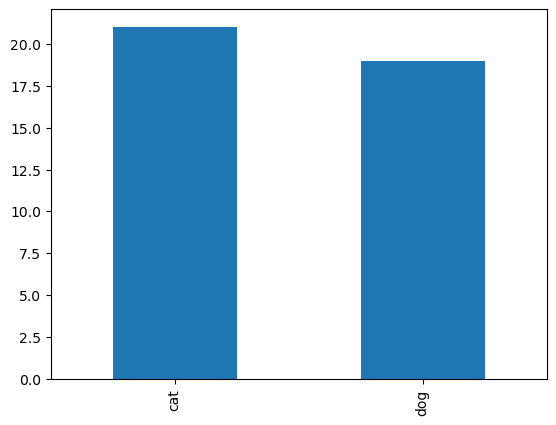

In [212]:
validate_df['category'].value_counts().plot.bar()

In [213]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator


In [214]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 160 validated image filenames belonging to 2 classes.


In [215]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 40 validated image filenames belonging to 2 classes.


In [216]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [217]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [246]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10


C:\Users\dipak\AppData\Local\Temp\ipykernel_20388\2528005629.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


10/10 [==============================] - 5s 480ms/step - loss: 0.2791 - accuracy: 0.8621 - val_loss: 1.2629 - val_accuracy: 0.7667 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 6s 554ms/step - loss: 0.3044 - accuracy: 0.8552 - val_loss: 1.3485 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 5s 533ms/step - loss: 0.3306 - accuracy: 0.8759 - val_loss: 1.7514 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 6s 608ms/step - loss: 0.3027 - accuracy: 0.8483 - val_loss: 1.6533 - val_accuracy: 0.7333 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 6s 552ms/step - loss: 0.3114 - accuracy: 0.8759 - val_loss: 1.3819 - val_accuracy: 0.7000 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 6s 540ms/step - loss: 0.2977 - accuracy: 0.8897 - val_loss: 1.8395 - val_accuracy: 0.6667 - lr: 1.0000e-05
Epoch 7/10
10/10 [==============================] - 5s 53

In [247]:
model.save_weights("model.h5")

# Virtualize Training

In [248]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [249]:
test_filenames = os.listdir("data/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [250]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


# Predict

In [251]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\dipak\AppData\Local\Temp\ipykernel_20388\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [252]:
test_df['category'] = np.argmax(predict, axis=-1)

In [253]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [254]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: >

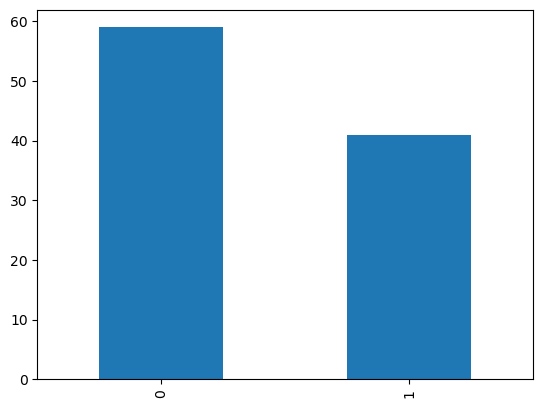

In [255]:
test_df['category'].value_counts().plot.bar()

In [256]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [257]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)